In [2]:
import datetime
import calendar
import collections

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain

from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [3]:
dataframe = pd.read_csv("database.csv", low_memory=False)
dataframe.head()

departure               return departure_id    departure_name  \
0  2020-03-23 06:09:44  2020-03-23 06:16:26           86          Kuusitie   
1  2020-03-23 06:11:58  2020-03-23 06:26:31           26        Kamppi (M)   
2  2020-03-23 06:16:29  2020-03-23 06:24:23          268  Porolahden koulu   
3  2020-03-23 06:33:53  2020-03-23 07:14:03          751        Vallipolku   
4  2020-03-23 06:36:09  2020-03-23 07:04:10           62  Länsisatamankatu   

  return_id       return_name  distance (m)  duration (sec.)  \
0     111.0     Esterinportti        1747.0            401.0   
1      10.0       Kasarmitori        1447.0            869.0   
2     254.0       Agnetankuja        1772.0            469.0   
3     106.0   Korppaanmäentie        7456.0           2406.0   
4     121.0  Vilhonvuorenkatu        7120.0           1679.0   

   avg_speed (km/h)  departure_latitude  departure_longitude  return_latitude  \
0          0.261397           60.195245            24.901900        60.197572   
1          0.099908           60.168610            24.930537        60.165017   
2          0.226695           60.195540            25.053581        60.187234   
3          0.185935           60.227827            24.819614        60.203474   
4          0.254437           60.158928            24.909692        60.186463   

   return_longitude  Air temperature (degC)  
0         24.926781                     0.9  
1         24.949473                     0.9  
2         25.036412                     0.9  
3         24.898930                     0.9  
4         24.967872                     0.9

In [4]:
dataframe[['departure','return']] =  dataframe[['departure','return']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

dataframe = dataframe.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'speed',
                                      'Air temperature (degC)':'temperature',
                                     })
dataframe = dataframe[ 
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)        
                    ]

# Create Graph Object


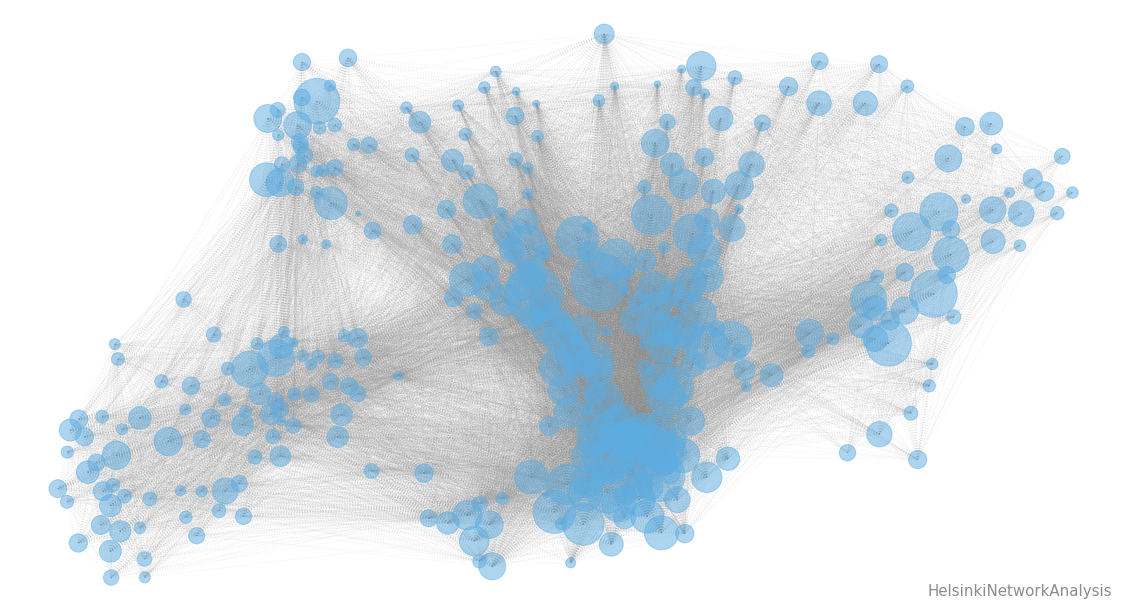

In [16]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    #print(df.isna().sum())
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    ax.axis('off')
    
    # Watermark
    ax.text(0.99, 0.01, 'HelsinkiNetworkAnalysis',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    return G

G = bikeNetwork(dataframe)

# Basic Network Stats

In [6]:
def networkStats(G):
    """
    This function prints the basic properties of the City bike network.
    """
    print(nx.info(G))
    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    #print(G.nodes['Kamppi (M)'])

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

networkStats(G)

Name: 
Type: Graph
Number of nodes: 347
Number of edges: 29604
Average degree: 170.6282
Network density: 0.49314520830904035
Triadic closure: 0.7490986589530844

Top 5 nodes by degree:

('Haukilahdenkatu', 312)
('Paciuksenkaari', 272)
('Huopalahdentie', 267)
('Laajalahden aukio', 262)
('Munkkiniemen aukio', 262)

Top 5 nodes by betweenness centrality:

('Haukilahdenkatu', 0.049350760236088746)
('Lehtisaarentie', 0.0071203742710766035)
('Lauttasaaren ostoskeskus', 0.006137945150459285)
('Aalto-yliopisto (M), Korkeakouluaukio', 0.005792495359391806)
('Paciuksenkaari', 0.005688626807042346)


The graph below illustrates bike usage in different areas of Helsinki during 2020. As expected the central Helsinki where most of the economic and cultural value is accumulated is the most active in terms of geographic mobility. However, as pointed out in the first part of this article, the geographic centre of Helsinki and the centre of Helsinki bike network are not the same. Where exactly is the centre of the city bike network?

In [21]:
def mapPlot(dataframe, year = 2020):
    """
    This function prints an interactive bubble plot by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    #df = df[:1000]
    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    #print(df.isna().sum())
    df["name"] = df["departure_name"]
    df = df[["name", "freq"]]
    df = df.drop_duplicates(subset=['name'])
    freq_dict = dict(zip(df.name, df.freq))

    df_stations = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv", index_col=False)
    df_stations = df_stations[df_stations["latitude"]<=60.254011]
    #print(df_stations.head())
    df_stations['freq']= df_stations['name'].map(freq_dict)
    #print(df_stations.head(), df_stations.isna().sum(), len(df_stations))
    df_stations["freq_adj"] = df_stations['freq']/(df_stations['freq'].median()/3)
    df_stations.fillna(1, inplace=True)
    df_stations.dropna(inplace=True)

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    for index, row in df_stations.iterrows():
        folium.CircleMarker([row['latitude'],row['longitude']],
                        radius=row["freq_adj"],
                        popup=row['freq'],
                        color="#eab544",
                        fill_color="#eab544",
                    ).add_to(hel_map)

    display(hel_map)
    
# function call is commented for performance reasons
mapPlot(dataframe)

In [8]:
def heatMapPlot(dataframe, year = 2020):
    """
    This function prints an interactive heatmap by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]

    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    
    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    stationArr = df[['departure_latitude', 'departure_longitude']].to_numpy()
    hel_map.add_child(plugins.HeatMap(stationArr, radius=15))

    display(hel_map)
    
# function call is commented for performance reasons
#heatMapPlot(dataframe)

# Network Centrality Measures 

Complex networks by definition are highly heterogeneous structures. This often results in some parts of the network being more information-rich than others. For example, in social networks, some individuals might have a large number of connections and can spread information faster than others. Hence, within the context of social network analysis, the nodes that represent them are considered more important(central). Within the context of transportation networks, an urban region where the influx of people is higher than in the other areas can be considered central. However, the centrality of a given network may change over time as a result of the growth and evolution of the underlying system. Thus, the definition of centrality is not absolute but rather depends on the specific context and the purpose of the abstraction. Taking this relativity into account, several centrality measures have been proposed that focus on different types of relationships between the nodes.

# Degree Centrality

Degree centrality is the most simple centrality measure to understand and compute. "Degree" of a node refers to the number of nodes that a given node is connected to. Within the context of city bikes, this refers to the number of bike stations that users have travelled to from the target station. As we can see in the graph below stations located in central Helsinki have a higher number of connections. Closer to the periphery of the network the degree of the nodes gradually decreases.

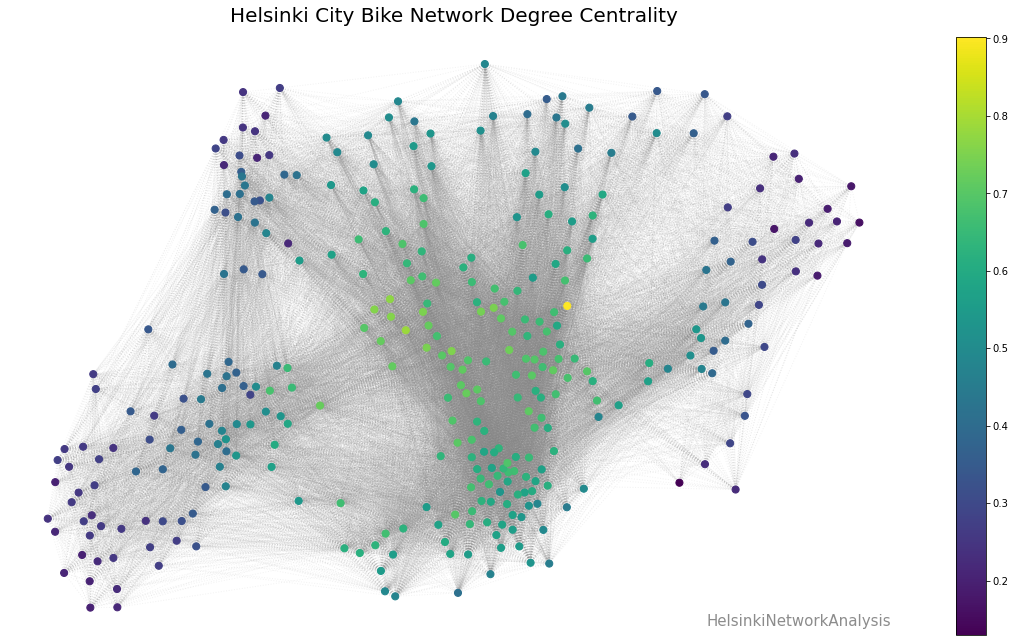

In [17]:
def centralityDegree(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'HelsinkiNetworkAnalysis',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


# function call is commented for performance reasons
centralityDegree(G)

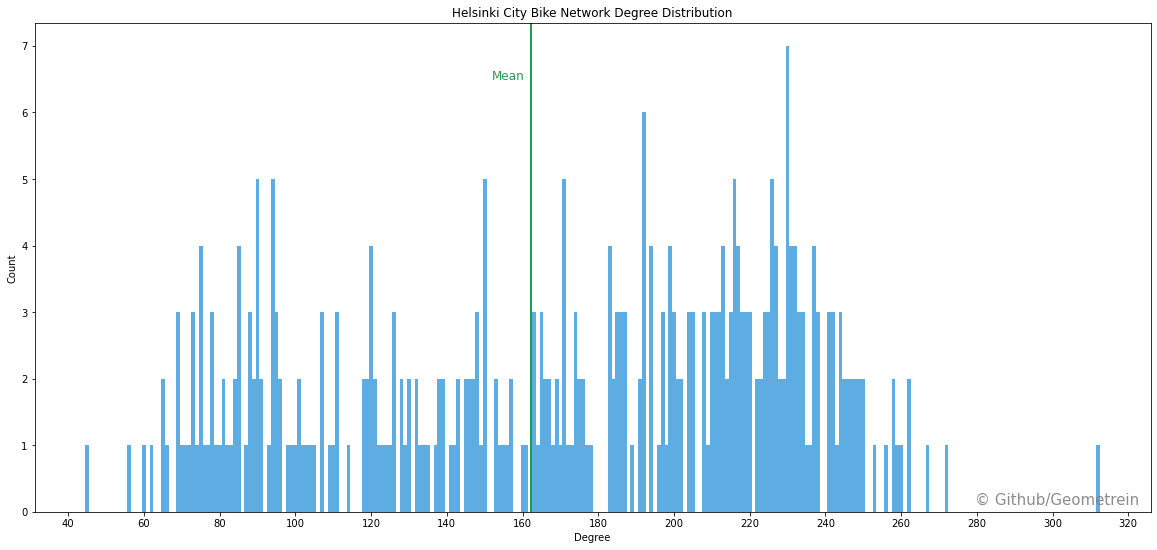

In [10]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.bar(deg, cnt, width=1, color=BLUE)
    plt.axvline(x = sum(deg)/len(deg), color=GREEN, linestyle='-', linewidth=2) # Degree Mean
    #plt.axvline(x = np.median(deg), color="blue", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("Helsinki City Bike Network Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.text(x= 152,y=6.5, s="Mean", color = GREEN, fontsize= 12)
    ax.set_xticks(range(40,340,20))

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
centralityDegreeDist(G)

The average degree of a node in the Helsinki city bike network is 162. This means that a bike station on average is connected to 162 different stations. The stations with the highest centrality degree are:

Haukilahdenkatu: 312 connections

Paciuksenkaari: 272 connections

Huopalahdentie: 267 connections

Laajalahden aukio: 262 connections

Munkkiniemen aukio: 262 connections

Töölöntulli: 260 connections

Tilkanvierto: 259 connections

Paciuksenkatu: 258 connections

Pasilan asema: 258 connections

Esterinportti: 256 connections

The fact that Haukilahdenkatu station is at the top of this list suggests that a large number of citizens from different districts make regular trips to and from this station. This could potentially mean that this station is either next to a large transportation hub or an important point of interest. Quick google search will reveal that it's located across the street from a large educational institution and a work rehabilitation centre. This explains both the regularity of the trips and the inflow of people from different suburban areas.

# Betweenness Centrality

The betweenness centrality captures how much a given node is "in-between" others. This measure calculates the shortest paths between all the nodes of the network and assigns each node a measure based on the number of shortest paths going through the target node. The graph below illustrates the city bike stations by betweenness centrality.

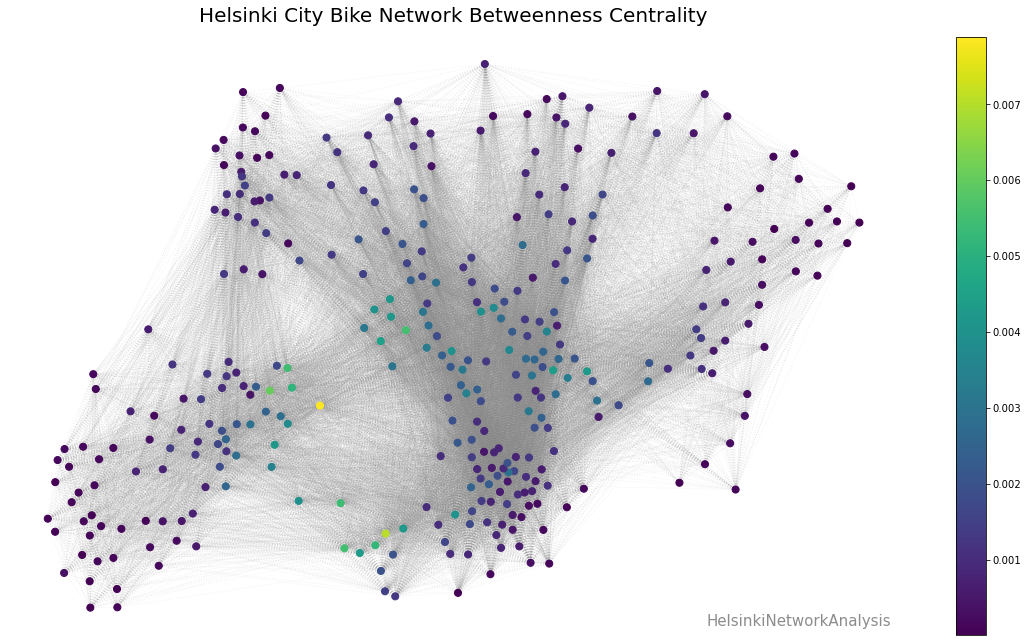

In [18]:
def centralityBetweenness(Graph): 
    """
    This function plots the city bike network betweenes centrality
    """
    
    G = Graph.copy(as_view=False)
    G.remove_node("Haukilahdenkatu")
        
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))
    
   

    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'HelsinkiNetworkAnalysis',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityBetweenness(G)

The node with the highest betweenness centrality represents the Lehtisaarentie station. This is a well-saturated example of geographic constraints affecting the structure of spatial networks. The station is located on the Lehtisaari island that links the Aalto University campus to Munkkiniemi and Helsinki. Due to the specificity of the Helsinki archipelago, traffic flows from one municipality to another are mostly channelled through island-bridge systems that lie in between. This makes both Lehtisaari and Lautasarri islands crucial traffic nodes connecting the municipality of Espoo to Helsinki.

# Closeness Centrality

Closeness centrality is a way of detecting nodes that are able to distribute flows efficiently through the network. The closeness centrality is calculated as the normalized average of all of its geodesic distances. Within the context of the city bikes, a node with high closeness centrality will indicate stations that can potentially act as versatile intermediary stations within the network.

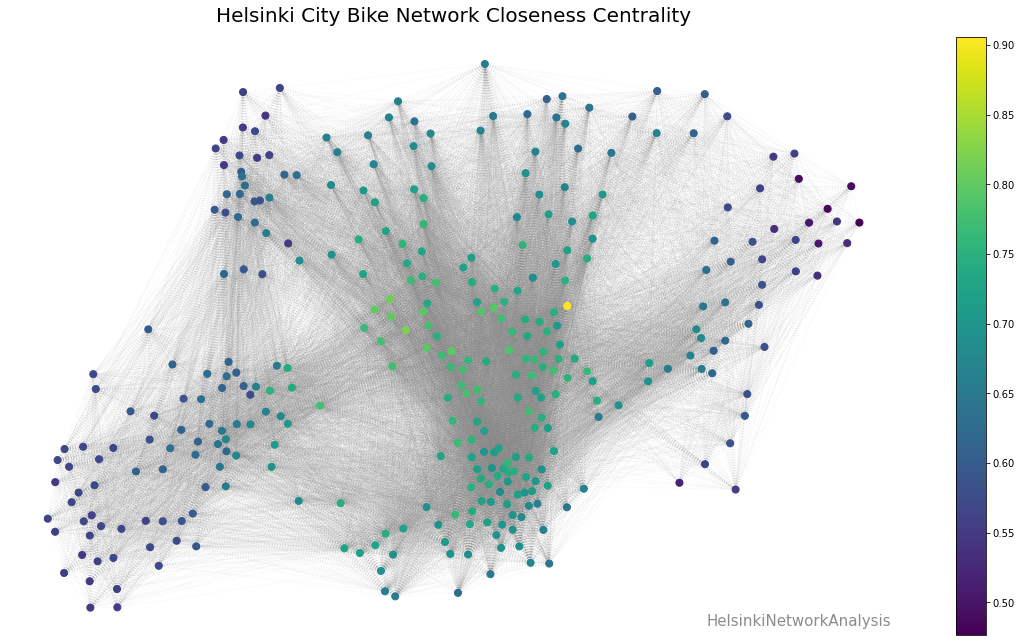

In [19]:
def centralityCloseness(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    closeness = nx.closeness_centrality(G)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Closeness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'HelsinkiNetworkAnalysis',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityCloseness(G)

As illustrated before a large amount of station is directly connected to Haukilahdenkatu station. This leads to Haukilahdenkatu station having the highest closeness centrality within the network. Other nodes with high closeness centrality are located in the areas of Töölo and Pasila. Closeness centrality might be interesting metrics for network optimization, especially for larger networks. In larger bike-sharing networks users might be motivated to make stops at the intermediary bike stations to avoid extra charges. However, as we have seen in the previous part of this article long trips are not common in Helsinki.

# Eigenvector centrality & PageRank

Eigenvector centrality measures a node's importance within the network while giving consideration to the importance of its neighbours. Connections to high-scoring eigenvector centrality nodes contribute more to the score than equal connections to low-scoring nodes. In other words, a node with a large number of connections may have a low Eigenvector score if all of its connections are with low-score nodes. A popular variation of eigenvector centrality is Google's PageRank. In essence, PageRank is a variation of normalized eigenvector centrality combined with random jumps. Thus it is not surprising that Pagerank yields result comparable to Eigenvector(graphs below). With this method, stations like the Central Railway Station, Pasila, Lehtisaarentie and Haukilahdenkatu appear as central nodes within the network.

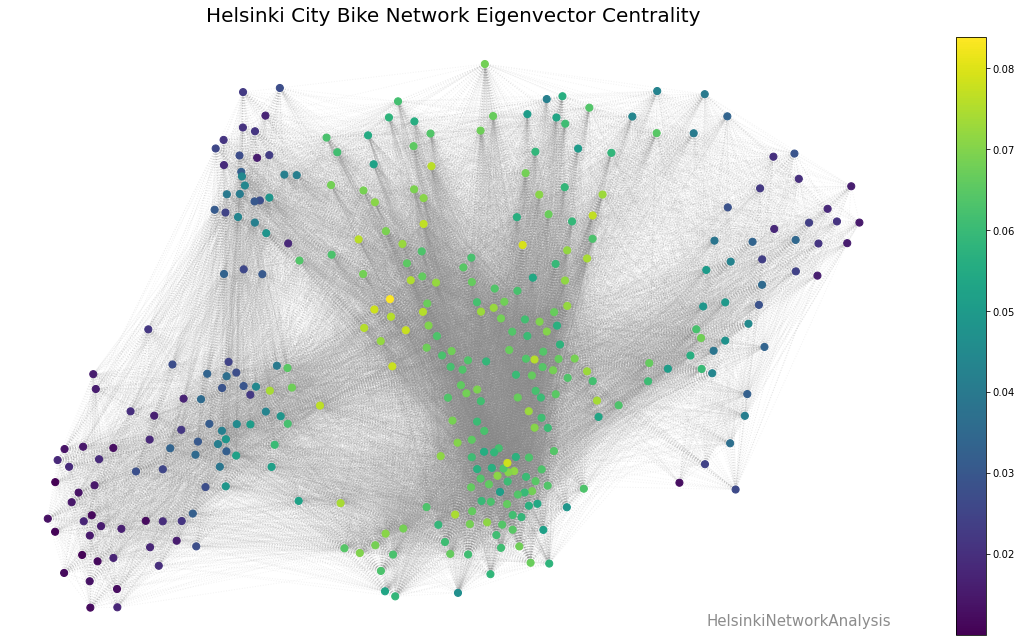

In [20]:
def centralityEigenvector(G):
    """
    This function plots the city bike network Eigenvector centrality
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    eigenvector = nx.eigenvector_centrality(G, max_iter=6000, weight="duration")
    node_color = [eigenvector[i] for i in eigenvector.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Eigenvector Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'HelsinkiNetworkAnalysis',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


# function call is commented for performance reasons
centralityEigenvector(G)

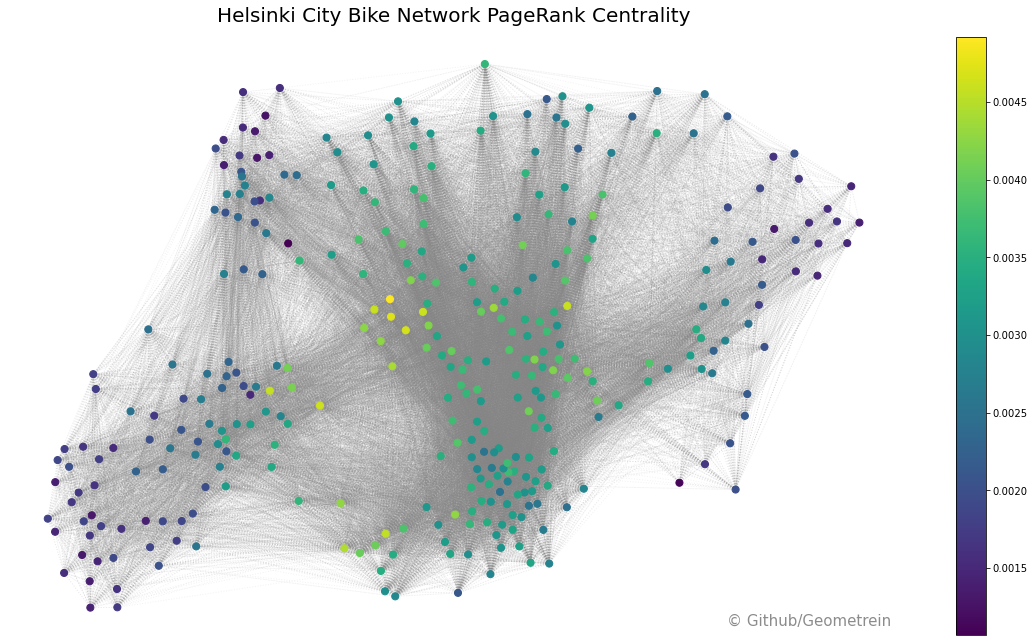

In [14]:
def centralityPageRank(dataframe, year=2020):
    """
    This function plots the city bike network nodes by PageRank
    """

    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    
    # Directed Graph
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, source='departure_name', target='return_name', edge_attr=['duration','distance'], create_using=nx.DiGraph())

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Phagerank
    phagerank = nx.algorithms.link_analysis.pagerank_alg.pagerank(G, weight="duration")
    node_color = [phagerank[i] for i in phagerank.keys()]

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Color Scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color=node_color, cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network PageRank Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

centralityPageRank(dataframe) 

The application of eigenvector and PageRank in an urban context is a subject of ongoing debate. It has been suggested that these metrics applied in an urban context often lead to misleading results since they ignore a multitude of urban qualities that might contribute to the importance of the node within the city. Some methods to overcome this issue propose adding an increasing amount of information to the graphs. This is a questionable approach since adding an increasing amount of information will inevitably introduce new arbitrary patterns within the data. Thus, these approaches often blur the clarity achieved by the act of abstraction creating a clear anti-pattern.

 While the limitation of Eigenvector centrality to capture urban qualities might be a problem in collective transportation systems where the routes of the services are predetermined, this is certainly not the case with individual transportation. As mentioned before, the structure of individual transportation networks is generated by the users therefore it already has the information about the urban qualities embedded in it. The fact that users have a choice and choose to take one path instead of the other creates a trivial voting mechanism that rates different areas of the city. Thus, in this kind of networks, the study of the structure of the network is also a study of user behaviour and their preferable urban qualities. Additionally, Eigenvector centrality in individual transportation networks allows highlighting not only important singular nodes but also geographically important areas within the city. This is possible because it acknowledges not only the importance of individual station but also the importance of stations adjacent to them. Eigenvector centrality illustrates that importance in the city bike stations(nodes) is derived no so much from their inherent attributes(location, station size) but rather from their relationships with other nodes within the network. Central stations together with nodes adjacent to them form small enclaves of activity. The identification of this kind of groupings of nodes within the context of complex networks is commonly referred to as community detection.